# <b>Data Exploration </b> *✲ﾟ*｡✧٩(･ิᴗ･ิ๑)۶*✲ﾟ*｡✧

## Intro

<b>What data?</b> <br> We are working with the immobilized whole brain imaging data from Kerem and Rebecca. They only include control data, meaning that the worm is a wild type and has no modification apart from the GFP. The data, which were originally stored in separate wbstruct.mat files, have been converted to a dictionary of pandas dataframes (stored in a pickle file for easier handling but also into separate h5 files and csv files for easier sharing). 

<b>What kind of exploration?</b> <br> 
We want to understand the individual datasets and get a feeling of what problems we might face, whether we need to do some processing before we start with the analysis. For now, we especially want to know and make following decisions:
- Are all neurons in each dataset IDed? (If no, remove)
- How many neurons are IDed in each dataset?
- How many times is each neuron IDed in total? (If too few, remove or impute)
- Are neurons with few total number of IDs unique? (If no, impute. Else remove)
- How to deal with missing IDs of nonunique neurons? Which imputation method? 

In [1]:
import dill  
import wbstruct_converter.utils.wbstruct_to_dicts as wbstruct_dictioniaries
import wbstruct_converter.utils.wbstruct_dicts_to_dataframes as wbstruct_dataframes
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import sys

#importing the module from the parent directory (needed for loading the pkl object)
from wbstruct_converter import utils
sys.modules['utils'] = utils

#if we want to reload the module
import importlib
importlib.reload(wbstruct_dataframes)

<module 'wbstruct_converter.utils.wbstruct_dicts_to_dataframes' from 'c:\\Users\\LAK\\Documents\\plots\\neumand\\data\\wbstruct_converter\\utils\\wbstruct_dicts_to_dataframes.py'>

## Some Quantifications 


We will first look at the number of IDs per neuron in all datasets and the number of IDs per dataset.

In [2]:
# load dataframe dictionaries
dataframes=wbstruct_dataframes.loading_pkl('dataframes_rebecca.pkl')
dataframes_kerem=wbstruct_dataframes.loading_pkl('dataframes_kerem.pkl')

# merging rebecas and kerems dataframe dictionaries
dataframes.update(dataframes_kerem)

# initialising the dictionaries for counting the IDs
all_IDed_neurons = Counter()
IDs_per_set = defaultdict()


for key, value in dataframes.items():
    # take only columns that have IDs (e.g. "AVAR","RIBL",..)
    IDed_neurons = [column for column in value.columns if "neuron" not in column]
    dataframes[key] = value[IDed_neurons]

    #some cleaning, removing question marks (rebecca's data), useless columns and duplicated columns 
    dataframes[key].columns = dataframes[key].columns.str.replace('?', '', regex=True)
    dataframes[key] = dataframes[key].loc[:, ~dataframes[key].columns.duplicated()] 
    dataframes[key] = dataframes[key].drop(columns=[columnname for columnname in ['is this OLQ or URA','OLQDLorR','masked','retrace',''] if columnname in dataframes[key].columns])
    
    # incrementing the counter for each ID
    for ID in list(dataframes[key].columns):
        all_IDed_neurons[ID] += 1

    # counting the number of IDs per dataset
    IDs_per_set[key] = len(dataframes[key].columns)

    
print("Count of IDed neurons per set: ", IDs_per_set,"\n")
print("Count of each neuron ID: ", all_IDed_neurons)


Count of IDed neurons per set:  defaultdict(None, {'20200629_w1': 59, '20200708_w3': 64, '20200714_w3': 62, '20200716_w2': 61, '20200724_w3': 41, '20200724_w4': 64, '20200826_w3': 54, '20200826_w6': 65, '20200922_w1': 57, '20200930_w4': 66, '20201007_w4': 66, '20210112_w3': 68, '20210113_w1': 71, '20210126_w2': 60, '20210203_w2': 72, '20210323_w6': 70, '20210324_w5': 67, '20210330_w5': 67, '20210414_w7': 67, 'Dataset1_20190125_ZIM1428_Ctrl_w2': 64, 'Dataset2_20180207_TKU862_Ctrl_w6': 58, 'Dataset3_20180112_TKU761_Ctrl_w1': 57, 'Dataset4_20170927_ZIM1428_Ctrl_w7': 49, 'Dataset5_20181217_ZIM1428_w2': 59, 'Dataset6_20190315_ZIM1428_1xHis_w1': 41}) 

Count of each neuron ID:  Counter({'AVAR': 25, 'AVAL': 25, 'ASKL': 25, 'AVER': 25, 'ALA': 25, 'RIMR': 25, 'AVFL': 25, 'SMDVL': 24, 'RID': 24, 'AVEL': 24, 'AIBR': 24, 'AVBR': 24, 'AIBL': 24, 'OLQVL': 23, 'RMED': 23, 'SMDVR': 23, 'AVFR': 23, 'VB01': 23, 'PVCL': 23, 'DVA': 23, 'AVBL': 23, 'OLQVR': 22, 'ASKR': 22, 'SMDDL': 22, 'SMDDR': 22, 'PVCR':

#### Let's visualize this information with a cute matplotlib plot 

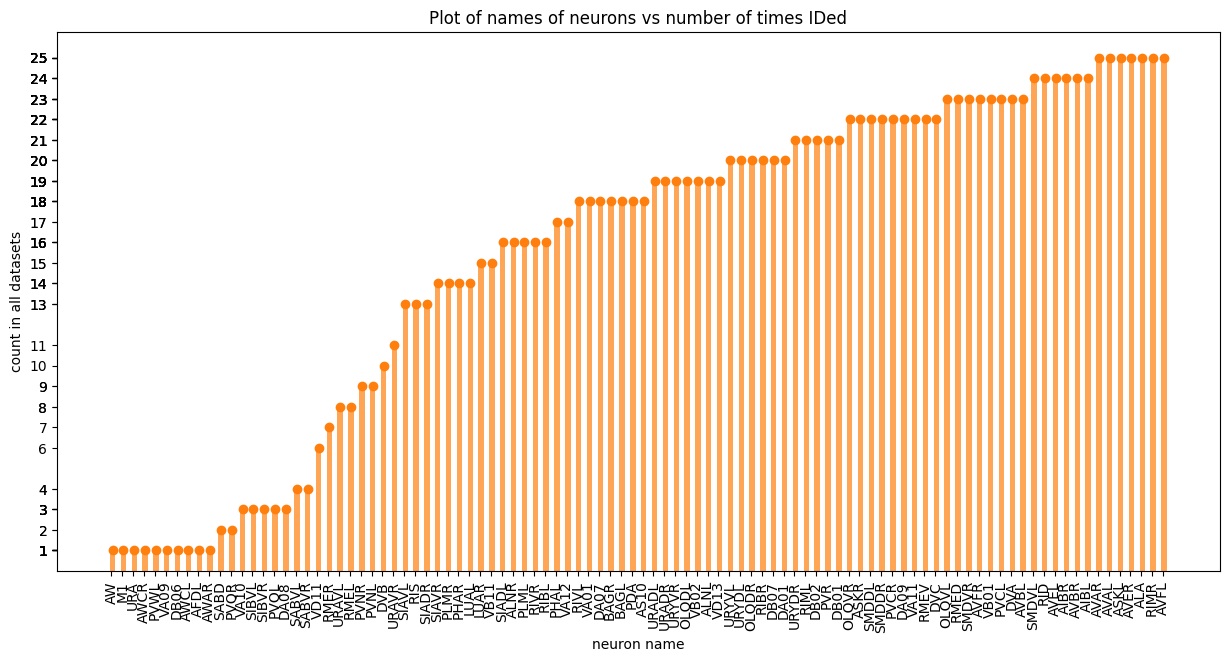

In [3]:
from matplotlib.ticker import MultipleLocator


sorted_neurons = dict(sorted(all_IDed_neurons.items(),
                      key=lambda item: item[1], reverse=False))
sorted_neurons_keys = list(sorted_neurons.keys())
sorted_neurons_values = list(sorted_neurons.values())

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 7))  # You can adjust the width as needed


# Create the cumulative bar chart and add markers on top of each bar
ax.bar(sorted_neurons_keys, sorted_neurons_values,
       color='tab:orange', alpha=0.7, width=0.5)
ax.plot(sorted_neurons_keys, sorted_neurons_values, marker='o',
        color='tab:orange', linestyle='', label='Markers')


x_positions = [sorted_neurons_key-0.1 for sorted_neurons_key in range(len(sorted_neurons_keys))]
# Set y-axis and x-axis labels
ax.set_yticks(sorted_neurons_values)
ax.set_xticks(x_positions)
# Adjust rotation and alignment as needed
ax.set_xticklabels(sorted_neurons_keys, rotation=90)

# Set the title and labels
ax.set_title("Plot of names of neurons vs number of times IDed")
ax.set_xlabel("neuron name")
ax.set_ylabel("count in all datasets")

# Show the plot
plt.show()


Most neurons are ID'ed more than 16 times while there are some neurons that are IDed less than 10 times. Considering we have 25 datasets, having to impute more IDs that exist in all datasets might not be a good idea. We could set a threshold to only impute IDs that are present in at least 10 datasets. This would reduce the number of IDs to impute to 25.
But before we make the cut we want to know how unique each neuron is. Let's say neuron RMER, which isn't IDed very much, is not very unique in the entirety of the datasets, meaning we could impute the recording of the neuron in all the datasets where it's missing. But if RMER is very unique, the imputation might lead to a completely wrong result.

## Uniqueness of neurons

So we want to know how unique each neuron is across all datasets. For this we could create for each neuron a linear model that takes all the other neurons into account and models that neuron.

In [4]:
colnames = list(all_IDed_neurons.keys())
stacked_dataframe = pd.DataFrame(columns=colnames)

for neuron in list(stacked_dataframe.columns):
    # set a minimum threshold for the number of times a neuron has to be IDed
    if all_IDed_neurons[neuron] > 3:
        try:
            # stack all dataframes vertically ~ stackety stack
            stacked_dataframe[neuron] = pd.concat([dataframes[key][neuron].reset_index(drop=True) for key in dataframes.keys() if neuron in dataframes[key].columns], ignore_index=True)
        except pd.errors.InvalidIndexError as e:
            print("Check any duplicates of following neuron: ", neuron)
    else:
        stacked_dataframe.drop(columns=neuron, inplace=True)

print("Shape of our stacked DF: ",stacked_dataframe.shape)
stacked_dataframe.head()
        

KeyboardInterrupt: 

### R-squared as a measure of uniqueness

We will run a Least Square Regression model n(=number of neurons) times where in each round y will be a single neuron and X will be all neurons but y. The aim is to see how well a neuron can be explained by all the other neurons. We can get a rough understanding of this by looking at the R-squared value of each LS model. 

<b>R-Squared R<sup>2</sup></b>
<br>
The R<sup>2</sup> measures the proportion of the neurons variance or spread explained by all the other neurons. R<sup>2</sup> ranges from 0 to 1 where 1 indicates that all the variance is explained by the other neurons and 0 indicates that none of the variance is explained by the other neurons. Now, if in our case the R<sup>2</sup>-value is high, we can say that the neuron is not very unique and we can impute the missing IDs. If the R<sup>2</sup>-value is low, we can say that the neuron is very unique and we should not impute the missing IDs.

In [ ]:
# dictionary for storing the R-Squared values
rsquareds = defaultdict()

for neuron in stacked_dataframe.columns:
    y = stacked_dataframe[neuron]
    X = stacked_dataframe.drop(columns=[neuron])
    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    rsquareds[neuron] = results.rsquared_adj

print("All R-Squared values: ", rsquareds, "\n")
    

All R-Squared values:  defaultdict(None, {'URADL': 0.9515093657288282, 'URADR': 0.956323352285909, 'URYVR': 0.9583152941246231, 'URYVL': 0.937754313772319, 'URYDR': 0.9501133290371218, 'URYDL': 0.9485610791842949, 'OLQDL': 0.9586500949463257, 'URAVL': 0.923162663213157, 'OLQVL': 0.940111272116861, 'URAVR': 0.913033354304848, 'RMED': 0.8637538175593328, 'OLQVR': 0.9227815099981307, 'OLQDR': 0.8804232182274982, 'SMDVL': 0.6654168852247131, 'AVAR': 0.9908351199409335, 'SMDVR': 0.7333766530955742, 'RID': 0.9323888546139293, 'AVAL': 0.9933268167164556, 'ASKL': 0.8798663168508566, 'ASKR': 0.8572197873394344, 'AVER': 0.9777696701248653, 'ALA': 0.9191446829052661, 'AVEL': 0.9798855676369836, 'AIBR': 0.9550280619325655, 'RIVL': 0.7567113723342355, 'RIBR': 0.8949677307431008, 'SIADL': 0.8866568592772711, 'RIML': 0.9623336252842699, 'RIMR': 0.9734165628514441, 'VB02': 0.9282600892478505, 'SMDDL': 0.684813555827428, 'SMDDR': 0.7940702946840469, 'SIAVR': 0.9203213463408519, 'SIAVL': 0.8460273888914

In [ ]:
for key, value in all_IDed_neurons.items():
    if value < 10 and value > 3:
        print(key, ":", rsquareds[key])

URAVL : 0.923162663213157
PVNR : 0.8656192695609757
RMER : 0.9046436767687339
PVNL : 0.9439482915966843
RMEL : 0.8538837162719575
VD11 : 0.8283113246266468
SABVL : 0.904631602064137
SABVR : 0.9220097634986549


weirdly enough, those neurons that are IDed the least seem to be modelled better than many other neurons where I would have assumed that they are better modelled, e.g. RIBR. How could this be? A further investigation is needed!
For now we will keep all neurons with more than 3 IDs and impute the missing IDs.

## ID imputation

In [4]:
sys.path.append('C:\\Users\\LAK\\Documents\\wbfm')
import wbfm.utils.general.postprocessing.utils_imputation as utils_imputation
import wbfm.utils.visualization.plot_traces as plot_traces


c:\Users\ZimAdmin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# we will set the threshold of minimum number of IDs that a neuron should have to 10
threshold = 10

stacked_dataframe = pd.concat([df for df in dataframes.values()], ignore_index=True)

# we will drop all neurons that have less than 10 IDs
stacked_dataframe = stacked_dataframe.drop(columns=[neuron for neuron in stacked_dataframe.columns if all_IDed_neurons[neuron] < threshold])
stacked_dataframe

,URADL,URADR,URYVR,URYVL,URYDR,URYDL,OLQDL,OLQVL,URAVR,RMED,...,DB01,DA01,DVB,DVC,PDA,AS10,VB11,RIVR,RIBL,SIADR
0,0.362247,0.268870,0.207330,0.304520,0.261854,0.264241,0.718043,0.424508,0.180676,0.262258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.334562,0.285975,0.232692,0.272279,0.240964,0.285008,0.698511,0.396316,0.195020,0.220053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.337621,0.274959,0.256516,0.311110,0.266116,0.299377,0.712704,0.426034,0.208328,0.226081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.297204,0.242873,0.176090,0.256018,0.224283,0.239688,0.644670,0.389113,0.171029,0.194837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.324939,0.239417,0.182565,0.268602,0.223360,0.254398,0.639860,0.389503,0.152927,0.193422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88539,NaN,NaN,NaN,NaN,0.070679,0.103842,0.145707,0.039689,NaN,0.809000,...,0.245616,0.406375,NaN,NaN,NaN,NaN,NaN,0.080279,0.035517,0.012778
88540,NaN,NaN,NaN,NaN,0.026907,0.063788,0.131263,0.040000,NaN,0.788587,...,0.242059,0.424368,NaN,NaN,NaN,NaN,NaN,0.064952,0.048814,0.030170
88541,NaN,NaN,NaN,NaN,0.073201,0.091530,0.141605,0.053817,NaN,0.790447,...,0.233480,0.413030,NaN,NaN,NaN,NaN,NaN,0.057847,0.038570,0.016279
88542,NaN,NaN,NaN,NaN,0.066290,0.097600,0.145602,0.063853,NaN,0.773798,...,0.223214,0.411529,NaN,NaN,NaN,NaN,NaN,0.070672,0.051676,0.007106


In [6]:
# the data is imputed with PPCA
imputed_dataframe = utils_imputation.impute_missing_values_in_dataframe(stacked_dataframe)
imputed_dataframe

c:\Users\ZimAdmin\AppData\Local\Programs\Python\Python310\lib\site-packages\ppca\_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))


,URADL,URADR,URYVR,URYVL,URYDR,URYDL,OLQDL,OLQVL,URAVR,RMED,...,DB01,DA01,DVB,DVC,PDA,AS10,VB11,RIVR,RIBL,SIADR
0,0.362247,0.268870,0.207330,0.304520,0.261854,0.264241,0.718043,0.424508,0.180676,0.262258,...,0.357489,0.791090,0.415103,0.971566,0.168150,0.414727,0.292866,0.369711,0.353604,0.315255
1,0.334562,0.285975,0.232692,0.272279,0.240964,0.285008,0.698511,0.396316,0.195020,0.220053,...,0.338471,0.781744,0.388422,0.934868,0.146640,0.383222,0.267643,0.354505,0.343220,0.318533
2,0.337621,0.274959,0.256516,0.311110,0.266116,0.299377,0.712704,0.426034,0.208328,0.226081,...,0.342967,0.761198,0.417349,0.952336,0.155311,0.404354,0.270802,0.370638,0.379899,0.303316
3,0.297204,0.242873,0.176090,0.256018,0.224283,0.239688,0.644670,0.389113,0.171029,0.194837,...,0.285276,0.714890,0.359308,0.881585,0.157874,0.376679,0.223743,0.318385,0.298164,0.272360
4,0.324939,0.239417,0.182565,0.268602,0.223360,0.254398,0.639860,0.389503,0.152927,0.193422,...,0.297652,0.704275,0.345400,0.866498,0.151395,0.370910,0.219837,0.320647,0.284763,0.259950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88539,0.071167,0.070806,0.108708,0.090632,0.070679,0.103842,0.145707,0.039689,0.062985,0.809000,...,0.245616,0.406375,0.240585,0.711203,0.227258,0.326731,0.163417,0.080279,0.035517,0.012778
88540,0.050874,0.064739,0.102674,0.083462,0.026907,0.063788,0.131263,0.040000,0.065431,0.788587,...,0.242059,0.424368,0.242806,0.683626,0.221014,0.314811,0.168166,0.064952,0.048814,0.030170
88541,0.073521,0.075924,0.105068,0.091498,0.073201,0.091530,0.141605,0.053817,0.064853,0.790447,...,0.233480,0.413030,0.235786,0.697634,0.229739,0.316606,0.149173,0.057847,0.038570,0.016279
88542,0.071775,0.071568,0.109740,0.093751,0.066290,0.097600,0.145602,0.063853,0.064707,0.773798,...,0.223214,0.411529,0.229215,0.687397,0.222404,0.321666,0.158086,0.070672,0.051676,0.007106


In [7]:
# we will save all dataframe keys and their lengths in a dictionary for the unstacking part
length_dict = defaultdict()
for key, value in dataframes.items():
    length_dict[key] = len(value)

In [11]:
%%capture 
#we don't want to output all plots, just save them

unstacked_dataframes = defaultdict()
start_index = 0
count = 0

# we will unstack the dataframe and plot the traces for each dataset
for obs_count in list(length_dict.values()):


    # we take the number of observations from the length dictionary and add it to the start index
    end_index = start_index + obs_count
    df_imputed = imputed_dataframe.iloc[start_index:end_index]
    df_unimputed = stacked_dataframe.iloc[start_index:end_index]

    # 2 dataframe grid plots, imputed in blue (first argument, such that it is in the back) and unimputed in orange (second argument, on top)
    fig = plot_traces.make_grid_plot_from_two_dataframes(df_imputed, df_unimputed)
    #fig, ax = plot_traces.make_grid_plot_from_dataframe(df_imputed)

    # save all plots in a folder
    key = list(length_dict.keys())[count]
    fig.savefig("C:\\Users\\LAK\\Documents\\imputed_plots\\"+key+".png")
    plt.close(fig)
    start_index = end_index
    count += 1
